# Ising model: Monte Carlo simulaties#

In [1]:
## indien tqdm niet geinstalleerd is in de volgende cel: verwijder comment # en run om te installeren
#!python -m pip install tqdm


In [2]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import numpy as np
from tqdm import tqdm
import copy

## 2D Ising model ##
Enkele globale parameters in ons model.

In [3]:
J      = 1.0          # De koppelings parameter in energie "meV" (1k_BT = 26meV@RT)
Bfield = 0.0       # Het magnetisch veld in Tesla
muB    = 5.788381e-2  # Bohrmagneton in meV/Tesla
B      = Bfield*muB   # Magnetisch veld in meV
T      = 25.0        # temperatuur in Kelvin
kBT    = T*8.617333e-2# k_B in meV/K

latdim = 10           # vierkant rooster
N      = latdim**2    # Aantal rooster sites 

De ondersteunende functies

In [4]:
def set_NNgrid(g: np.ndarray, dim):
    """ 
    Set the NN interactions for each individual site
    
    """  
    km=np.arange(-1,-1+dim) #lookup-tables for shifted sites, indexing starts at zero in python
    km[0]=dim-1             #stel de eerste gelijk aan het laatste element
    kp=np.arange(1,1+dim) 
    kp[-1]=0                #stel het laatste element gelijk aan het eerste
    
    for i in range(dim):
        for j in range(dim):
            g[1,i,j]=g[0,i,j]*(g[0,kp[i],j]+g[0,km[i],j]+g[0,i,kp[j]]+g[0,i,km[j]])

            
def calc_TotE(g: np.ndarray,dim)-> float:
    """ 
    Calculate the total energy of the 2D Ising model using global J & B
    parameters:
        - g  : 2D grid of lattice sites & values (2 lagen: 0=de site toestanden, 1=de NN interacties)
        
    """
    TE = 0.0
    for i in range(dim):
        for j in range(dim):
            TE -= B*g[0,i,j] # de bijdrage tgv interactie met magnetische veld 
            TE -= 0.5*J*g[1,i,j] # de bijdrage tgv interactie tussen NN sites (0.5 want halve bonds)
    return TE/N #geef de totale energie gemiddeld per site als resultaat
    
def calc_TotM(g: np.ndarray)-> float:
    """ 
    Calculate the total magnetic moment of the 2D Ising model
    parameters:
        - g  : 2D grid of lattice sites & values (2 lagen: 0=de site toestanden, 1=de NN interacties)
        
    """
    #we kunnen sommeren via een dubbele lus, of gebruik maken van de "sum"
    #functie van numpy. 
    # - g[0,:,:] is de 2D matrix met spins
    # - de eerste sum kan over axis=0(rijen) of axis=1(kolomen) zijn en geeft een vector als resultaat
    # - de tweede sum kan enkel over axis=0 want we passen dit op een vector toe
    M=g[0,:,:].sum(axis=0).sum(axis=0)
    M/=N #delen door het aantal roosterposities
    return M
    
def do_Nupdates(g: np.ndarray, Nstep: int, J, B, kT: float, dim):
    """
    Perform Nstep atomic updates of the Ising system.
    
    parameters:
        - g  : 2D grid of lattice sites & values (2 lagen: 0=de site toestanden, 1=de NN interacties)
        - Nstep : Number of steps
        - J, B : the J and B constants
        - kT : The kBT value
    """
    km=np.arange(-1,-1+dim) #lookup-tables for shifted sites, indexing starts at zero in python
    km[0]=dim-1             #stel de eerste gelijk aan het laatste element
    kp=np.arange(1,1+dim) 
    kp[-1]=0                #stel het laatste element gelijk aan het eerste
    #selecteer Nstep random gridpunten
    rpt=np.random.randint(low=0,high=dim,size=(Nstep,2))
    rn=np.random.rand(Nstep)
    
    for i in range(Nstep):
        dE= (2*J*g[1,rpt[i,0],rpt[i,1]]+2*B*g[0,rpt[i,0],rpt[i,1]]) #dE=-(2Eold)=-(-2Js1s2)=2Js1s2
        update=(dE<0)                                               #dE is voor volledige bond! dus 2xJ
        if not update: #is het uphill?
            r=rn[i] # random number [0,1[
            update=(r<np.exp(-dE/kT)) #houden we de uphill configuratie of niet?
        if update:# voer nu de update praktisch uit
            g[0,rpt[i,0],rpt[i,1]]=-g[0,rpt[i,0],rpt[i,1]] #flip sign site spin
            g[1,rpt[i,0],rpt[i,1]]=-g[1,rpt[i,0],rpt[i,1]] #flip sign site omgevingsinteractie
            #impact van signflips op NN?
            ls=2*g[0,rpt[i,0],rpt[i,1]]  # de verandering bestaat uit 2x de nieuwe waarde
            g[1,kp[rpt[i,0]],rpt[i,1]]+= g[0,kp[rpt[i,0]],rpt[i,1]]*ls
            g[1,km[rpt[i,0]],rpt[i,1]]+= g[0,km[rpt[i,0]],rpt[i,1]]*ls
            g[1,rpt[i,0],kp[rpt[i,1]]]+= g[0,rpt[i,0],kp[rpt[i,1]]]*ls
            g[1,rpt[i,0],km[rpt[i,1]]]+= g[0,rpt[i,0],km[rpt[i,1]]]*ls

def do_Gridupdate(g: np.ndarray, J, B, kT, dim):
    """
    Perform atomic updates of all the gridpoints in the Ising system.
    
    parameters:
        - g  : 2D grid of lattice sites & values (2 lagen: 0=de site toestanden, 1=de NN interacties)
        - J, B : the J and B constants
        - kT : The kBT value
    """
    #maak een nieuw grid
    g2=np.zeros((dim,dim))
    rn=np.random.rand(dim,dim)
    
    #flip=np.zeros((dim,dim),dtype=bool)
    for i in range(dim):
        for j in range(dim):
            dE=(2*J*g[1,i,j]+2*B*g[0,i,j])
            update=(dE<0)
            #print("(i,j)=",i,j," dE=",dE," J=",J*g[1,i,j],"  B=",2*B*g[0,i,j]," update(dE<0)=",update)
            if not update: #is het uphill?
                r=rn[i,j] # random number [0,1[
                update=(r<np.exp(-dE/kT)) #houden we de uphill configuratie of niet?
                #print("r=",r," dE=",dE," exp=",np.exp(-dE/kBT)," update=",update)
            if update:# voer nu de update praktisch uit
                g2[i,j]=-g[0,i,j] #flip sign site spin
            else:
                g2[i,j]=g[0,i,j]  #no flip sign site spin
            #flip[i,j]=update
    g[0,:,:]=copy.deepcopy(g2) #maak een echte kopie
    set_NNgrid(g,dim) #en update de NN interacties
    #print(flip)

def do_GridupdateWr(g: np.ndarray, J, B, kT,dim):
    """
    Perform atomic updates of all the gridpoints in the Ising system.
    This setup is inherently wrong!
    
    parameters:
        - g  : 2D grid of lattice sites & values (2 lagen: 0=de site toestanden, 1=de NN interacties)
        - J, B : the J and B constants
        - kT : The kBT value
    """
    km=np.arange(-1,-1+dim) #lookup-tables for shifted sites, indexing starts at zero in python
    km[0]=dim-1             #stel de eerste gelijk aan het laatste element
    kp=np.arange(1,1+dim) 
    kp[-1]=0                #stel het laatste element gelijk aan het eerste
    rn=np.random.rand(dim,dim)
    
    for i in range(dim):
        for j in range(dim):
            dE=(2*J*g[1,i,j]+2*B*g[0,i,j])
            update=(dE<0)
            if not update: #is het uphill?
                r=rn[i,j] # random number [0,1[
                update=(r<np.exp(-dE/kT)) #houden we de uphill configuratie of niet?
            if update:# voer nu de update praktisch uit
                g[0,i,j]=-g[0,i,j] #flip sign site spin
                g[1,i,j]=-g[1,i,j] #flip sign site omgevingsinteractie
                #impact van signflips op NN?
                ls=2*g[0,i,j]  # de verandering bestaat uit 2x de nieuwe waarde
                g[1,kp[i],j]+= g[0,kp[i],j]*ls
                g[1,km[i],j]+= g[0,km[i],j]*ls
                g[1,i,kp[j]]+= g[0,i,kp[j]]*ls
                g[1,i,km[j]]+= g[0,i,km[j]]*ls

### De main loop ###
In de volgende cel wordt de hoofdlus doorlopen.

<IPython.core.display.Javascript object>


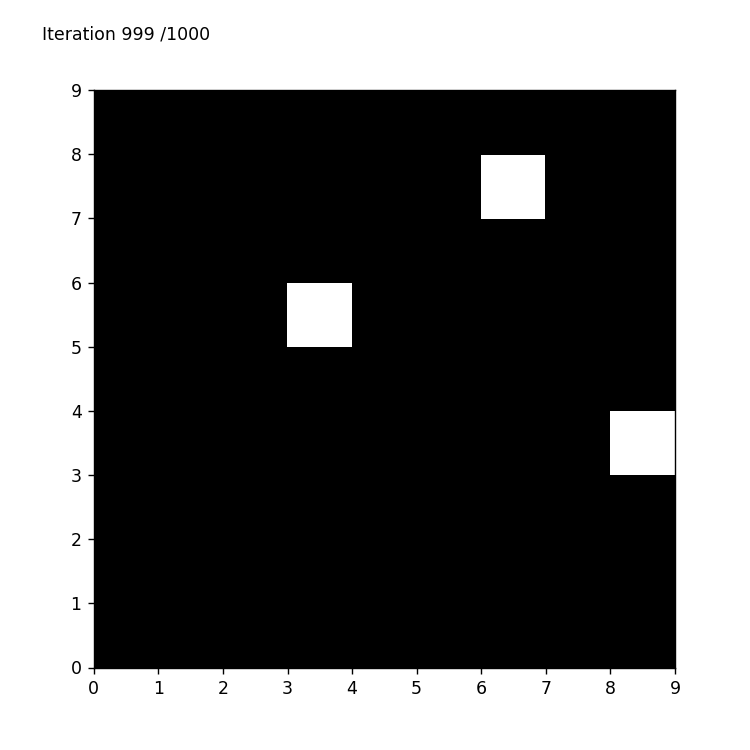

grid-shape: <class 'numpy.ndarray'>  -> (2, 10, 10)
X : <class 'numpy.ndarray'>  ->  (10,) [0 1 2 3 4 5 6 7 8 9]
Y : <class 'numpy.ndarray'>  ->  (10, 1) [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


In [6]:
# we willen een animatie maken van ons spin rooster evolutie
%matplotlib notebook
fig = plt.figure(figsize=(6,6))
x = np.arange(0, latdim)
y = np.arange(0, latdim).reshape(-1, 1)
frames = list()

## initialiseer het grid
#grid=np.random.randint(low=0,high=2,size=(2,latdim,latdim))
grid=np.zeros((2,latdim,latdim))
grid[0,:,:]=(((grid[0,:,:]*1.0)-0.5)*2.0) # van (0,1)->(-1,1)
set_NNgrid(grid,latdim) # grid waar we de lokale gridomgeving opslaan is grid[1,:,:]
#print(grid[1])

print("grid-shape:",type(grid)," ->",grid.shape)
print("X :",type(x)," -> ",x.shape,x)
print("Y :",type(y)," -> ",y.shape,y)

## Eigenschappen die we willen volgen
propE = list() # De totale energie van het systeem
propM = list() # De totale magnetisatie van het systeem
avgE  = list() # lopend gemiddelde waarden
avgM  = list()
Ninit = N*2    # Initieel aantal stappen welke genegeerd worden
Nup   = N*1    # Data-punt wordt opgeslagen elke Nup atomaire updates
Nconf = 1000   # Het aantal configuraties om te genereren

E_old=calc_TotE(grid,latdim) # Bereken totale potentiële energie
#do_Nupdates(grid, Ninit, J, B , kBT)     # De eerste N updates gooien we weg
                                #(indien bij een niet random grid wordt gestart)
#bar = tqdm(total=Nconf)
fr=np.zeros((Nconf,latdim,latdim))

for i in range(Nconf): 
    #doe de update
    #do_Nupdates(grid, Nup, J, B , kBT,latdim) # zoals het hoort
    do_GridupdateWr(grid, J, B , kBT,latdim) # versie zoals het boek
    #do_Gridupdate(grid, J, B , kBT,latdim) # versie zoals het boek had moeten zijn
    
    #verzamel de data
    propE.append(calc_TotE(grid,latdim))
    propM.append(calc_TotM(grid))
    avgE.append(np.mean(propE))
    avgM.append(np.mean(propM))
    title="Iteration "+str(i)+" /"+str(Nconf)
    ttl = plt.text(0.5, 10.0, title, horizontalalignment='center', verticalalignment='top')
    frames.append((plt.pcolor(x, y,grid[0,:,:] , cmap="gray", 
                              norm=plt.Normalize(0, 1),label=title), ttl, ))
#    bar.update()#plot a progressbar :-)
#bar.close()

im_ani = animation.ArtistAnimation(fig, frames, interval=100, repeat_delay=10,
                                   blit=False)
im_ani.save('Ising2D.gif', dpi=40, writer='imagemagick', fps = 60, bitrate = 1500, 
            metadata={'artist':'https://DannyVanpoucke.be'})
# To save this second animation with some metadata, use the following command:
plt.show()


## Plot de resultaten ##

In [ ]:
%matplotlib inline
# De energie
plt.figure(figsize=(16,6))
x=np.arange(Nconf)

plt.plot(x, propE, color="red"   ,linewidth=1, zorder=-1, alpha=1)
plt.plot(x, avgE,  color="blue"  ,linewidth=1, zorder=-1, alpha=1)

plt.xscale("linear")
plt.yscale("linear")
#maxE=abs(2*J)+abs(B)
maxE=max([abs(min(propE)),max(propE)])*1.1
plt.axis([0,Nconf,-maxE,maxE])
Xlst=np.linspace(0,Nconf,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-5,5,11))*(maxE*0.2)
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# simulatie stap",fontsize=22,fontweight="bold")
plt.ylabel("E per site (meV)",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.show()

In [ ]:
# De magnetisatie
plt.figure(figsize=(16,6))
x=np.arange(Nconf)

plt.plot(x, propM, color="red"   ,linewidth=1, zorder=-1, alpha=1)
plt.plot(x, avgM,  color="blue"  ,linewidth=1, zorder=-1, alpha=1)

plt.xscale("linear")
plt.yscale("linear")
#maxE=abs(2*J)+abs(B)
maxM=max([abs(min(propM)),max(propM)])*1.25
plt.axis([0,Nconf,-maxM,maxM])
Xlst=np.linspace(0,Nconf,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-5,5,11))*(maxM*0.2)
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# simulatie stap",fontsize=22,fontweight="bold")
plt.ylabel("M per site",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.show()

# Ising: kritische temperature #


In [ ]:
J      = 1.0          # De koppelings parameter in energie "meV" (1k_BT = 26meV@RT)
Bfield = 0.0       # Het magnetisch veld in Tesla
muB    = 5.788381e-2  # Bohrmagneton in meV/Tesla
B      = Bfield*muB   # Magnetisch veld in meV
nT     = 50
scale  = 1.0
T      = np.arange(start=1,stop=1+nT, step=1)*scale # temperatuur in Kelvin
kBT    = T*8.617333e-2# k_B in meV/K

latdim = 30           # vierkant rooster
N      = latdim**2    # Aantal rooster sites 
Ninit = N*2    # Initieel aantal stappen welke genegeerd worden
Nup   = N*1    # Data-punt wordt opgeslagen elke Nup atomaire updates
Nconf = 100   # Het aantal configuraties om te genereren

# lijsten om de uiteindelijk gemiddelde waarden van de simulaties op te slaan per T
TavgE = np.zeros((nT,3))
TavgM = np.zeros((nT,3))

bar = tqdm(total=nT)
for nrT in range(nT):
    ## initialiseer het grid
    #grid=np.random.randint(low=0,high=2,size=(3,2,latdim,latdim))
    grid=np.zeros((3,2,latdim,latdim))
    grid[:,0,:,:]=(((grid[:,0,:,:]*1.0)-0.5)*2.0) # van (0,1)->(-1,1)
    set_NNgrid(grid[0],latdim) # grid waar we de lokale gridomgeving opslaan is grid[1,:,:]
    set_NNgrid(grid[1],latdim) 
    set_NNgrid(grid[2],latdim) 
    
    ## Eigenschappen die we willen volgen
    propE = [list(),list(),list()] # De totale energie van het systeem
    propM = [list(),list(),list()] # De totale magnetisatie van het systeem
    
    do_Nupdates(grid[0], Ninit, J, B , kBT[nrT],latdim)     # De eerste N updates gooien we weg(indien bij een niet random grid wordt gestart)
    do_GridupdateWr(grid[1], J, B , kBT[nrT],latdim) # versie zoals het boek
    do_Gridupdate(grid[2], J, B , kBT[nrT],latdim) # versie zoals het boek had moeten zijn
    for i in range(Nconf): 
        #doe de update
        do_Nupdates(grid[0], Nup, J, B , kBT[nrT],latdim) # zoals het hoort
        do_GridupdateWr(grid[1], J, B , kBT[nrT],latdim) # versie zoals het boek
        do_Gridupdate(grid[2], J, B , kBT[nrT],latdim) # versie zoals het boek had moeten zijn
    
        #verzamel de data
        propE[0].append(calc_TotE(grid[0],latdim))
        propE[1].append(calc_TotE(grid[1],latdim))
        propE[2].append(calc_TotE(grid[2],latdim))
        propM[0].append(calc_TotM(grid[0]))
        propM[1].append(calc_TotM(grid[1]))
        propM[2].append(calc_TotM(grid[2]))
        
    TavgE[nrT]=np.mean(propE,axis=1) 
    TavgM[nrT]=abs(np.mean(propM,axis=1))
    bar.update()#plot a progressbar :-)
bar.close()

## plot resultaten ##

In [ ]:
# De energie
plt.figure(figsize=(16,6))

plt.plot(T, TavgE[:,0], color="red"   ,linewidth=1, zorder=-1, alpha=1, label="Rand Updates")
plt.plot(T, TavgE[:,1], color="blue"   ,linewidth=1, zorder=-1, alpha=1, label="full-grid 'wrong'")
plt.plot(T, TavgE[:,2], color="black"   ,linewidth=1, zorder=-1, alpha=1, label="full-grid 'correct'")


plt.xscale("linear")
plt.yscale("linear")
maxE=max([abs(np.amin(TavgE[:,])),np.amax(TavgE)])
plt.axis([0,nT*scale,np.amin(TavgE),np.amax(TavgE)])
Xlst=np.linspace(0,nT*scale,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-5,5,11))*(maxE*0.2)
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# temperatuur [K]",fontsize=22,fontweight="bold")
plt.ylabel("E per site (meV)",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.legend()
plt.show()

In [ ]:
# De magnetisatie
plt.figure(figsize=(16,6))

plt.plot(T, TavgM[:,0], color="red"   ,linewidth=1, zorder=-1, alpha=1, label="Rand Updates")
plt.plot(T, TavgM[:,1], color="blue"   ,linewidth=1, zorder=-1, alpha=1, label="full-grid 'wrong'")
plt.plot(T, TavgM[:,2], color="black"   ,linewidth=1, zorder=-1, alpha=1, label="full-grid 'correct'")


plt.xscale("linear")
plt.yscale("linear")
maxM=max([abs(np.amin(TavgM)),np.amax(TavgM)])
plt.axis([0,nT*scale,-0.1,np.amax(TavgM)*1.1])
Xlst=np.linspace(0,nT*scale,11)
plt.xticks(Xlst,rotation=45,fontsize=18)
Ylst=(np.linspace(-1,11,13))*0.1
plt.yticks(Ylst,fontsize=18)

plt.xlabel("# temperatuur [K]",fontsize=22,fontweight="bold")
plt.ylabel("M per site",fontsize=22,fontweight="bold")
plt.grid(b=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.show()